In [26]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os

In [2]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933}

/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/025f995f9f588fd4c2a883f3bdec2b7a 2.3
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/44ceac13d4ddf97a464202f008298016 2.0
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/6d7584175ba0c9c28175589604d8cb45 2.2
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/2a1b91b6180297992da63e6b70935adc 1.5
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/317cd6998cbc2880bf7c22994f9ac7f4 1.9
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/0f3aabe762804918c13c279e8901bb02 2.5
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/d3d61800dd0bbc013b833dddf67cbc5e 1.4
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/859424371d74da5417e895b9c2356fd4 1.8
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/1ade6d7a46c4412452072811bf21f

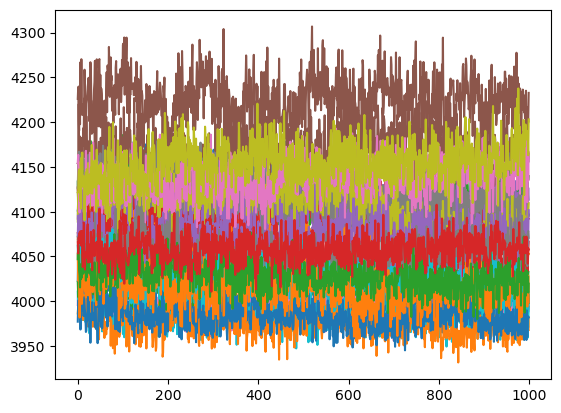

In [13]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2}
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    #plt.plot(vol[3600:])
    #plt.plot(temp[3950:])
    plt.plot(vol[-3000:])
    print(job.path, job.sp.kT)

In [14]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2}
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    #sample_idx = len(vol)//2
    sample_idx = 0
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.20, threshold_neff=100)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.20, threshold_neff=100)[0]
    print(job.sp.kT, vol_eq, pe_eq)
    if all([vol_eq, pe_eq]):
        print("equilibrated")
        job.doc.equilibrated = True
    print()

2.3 True True
equilibrated

2.0 True True
equilibrated

2.2 True True
equilibrated

1.5 True True
equilibrated

1.9 True True
equilibrated

2.5 True True
equilibrated

1.4 True True
equilibrated

1.8 True True
equilibrated

1.95 True True
equilibrated

1.3 True True
equilibrated

1.6 True True
equilibrated

1.25 True True
equilibrated

1.2 True True
equilibrated

1.1 True True
equilibrated

2.1 True True
equilibrated

2.6 True True
equilibrated

1.85 True True
equilibrated

1.75 True True
equilibrated

2.4 True True
equilibrated

1.65 True True
equilibrated

1.35 False True

1.55 True True
equilibrated

1.7 True True
equilibrated

1.45 True True
equilibrated



In [15]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2}
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    #sample_idx = len(vol)//2
    sample_idx = 0
    try:
        uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
            vol[sample_idx:], threshold_fraction=0.20, threshold_neff=100
        )
    except:
        print(job.id)
        continue
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    #np.savetxt(job.fn("vol_sample_indices.txt"), uncorr_indices + sample_idx)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


c40a15910a2264d76ed8bf6c9e15ce1c


1.1 1.3663400559795134
1.2 1.373999560931971
1.25 1.3933312330075804
1.3 1.3884839412382568
1.4 1.3830104071183298
1.45 1.3625788924907534
1.5 1.3471527860326924
1.55 1.3798793980069048
1.6 1.380218981896013
1.65 1.3752733525528271
1.7 1.3737411146875749
1.75 1.3613134223323147
1.8 1.3447165947927358
1.85 1.3347169042584288
1.9 1.3450518570573935
1.95 1.3582520653652577
2.0 1.3569534238343826
2.1 1.3581417615062608
2.2 1.3426220154235895
2.3 1.346115080395727
2.4 1.3297193357991997
2.5 1.3244153234136522
2.6 1.307416868394076


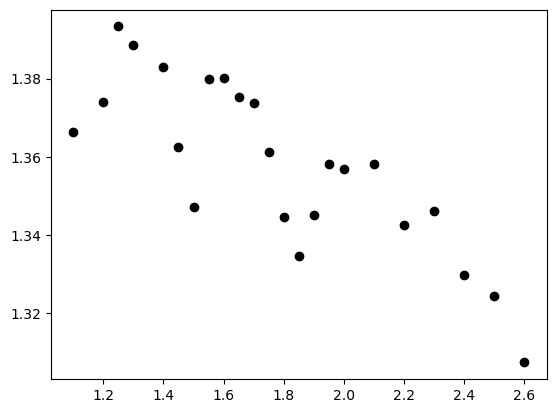

In [17]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2}
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    if job.doc.equilibrated:
        try:
            print(kT, job.doc.avg_density)
            #print(kT, job.path)
            plt.plot(kT, job.doc.avg_density, "ko")
            #plt.vlines(x=1.67, ymin=0.68, ymax=0.72, ls="--", color="red")
        except:
            continue

1.1 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/f2c809e8c27b8f46b22124fcac4ed09b
1.2 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/2e5e7394f137a33dcfec0cf173cf13e0
1.25 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/43a158a7135bc1643a671e10248f6740
1.3 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/28087f6c5e62e692ffe6b1de1a642e69
1.35 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/c40a15910a2264d76ed8bf6c9e15ce1c
1.4 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/d3d61800dd0bbc013b833dddf67cbc5e
1.45 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/1d5563b81e7874fa90384ca7b2ad9d4f
1.5 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/2a1b91b6180297992da63e6b70935adc
1.55 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/e79610cfe04ec2524b100

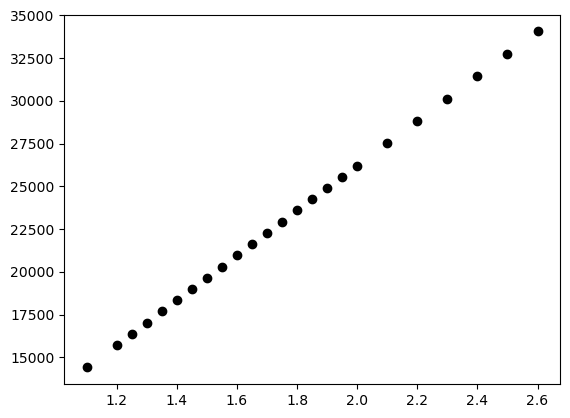

In [36]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2}
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    ke = data["mdcomputeThermodynamicQuantitieskinetic_energy"]
    plt.plot(kT, np.mean(ke), "ko")
    print(kT, job.path)

In [32]:
data["mdcomputeThermodynamicQuantitieskinetic_energy"]

array([19180.36364, 18768.18109, 18781.29679, 18955.71886, 18974.73287,
       19072.31198, 18585.35922, 19264.15797, 18969.48445, 18720.89999,
       18638.49511, 18804.09412, 19286.60597, 19207.41064, 18906.51706,
       19291.31303, 18734.58456, 19227.72467, 19083.31659, 18917.33666,
       18826.72698, 18849.15631, 19165.73568, 18965.80933, 18893.80956,
       18916.3547 , 18969.62305, 19087.53962, 18928.02816, 18878.46402,
       18886.8218 , 19043.10291, 19042.92928, 19164.67038, 18993.30167,
       19092.52374, 18948.67797, 19142.23027, 18822.63323, 19171.97371,
       18959.46294, 19122.71135, 18997.2862 , 18974.69551, 18968.22591,
       18900.99299, 19157.55339, 18830.5532 , 19094.1858 , 18879.01336,
       19110.54026, 19017.16626, 19136.19803, 19085.72399, 18926.34071,
       19006.66315, 18611.76788, 18883.09437, 18897.43105, 18944.03949,
       18864.11506, 19319.34338, 18890.29533, 18989.57866, 18978.7704 ,
       18811.95216, 18780.90265, 19095.49145, 19181.70321, 18986

In [37]:
for job in project:
    job.doc.msd_sampled = False

In [38]:
for job in project:
    print(job.doc.volume_sampled)

True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
